# Convolutional Neural Networks (CNNs)
CNNs are a family of models that were originally inspired by how the visual cortex of the human brain works when recognizing objects. The development of CNNs goes back to the 1990s, when Yann LeCun and his colleagues proposed a novel NN architecture for classifying handwritten digits from images.
Due to the outstanding performance of CNNs for image classification tasks, this particular type of feedforward NN gained a lot of attention and led to tremendous improvements in machine learning for computer vision.

Successfully extracting **salient** (relevant) features is key to the performance of any machine learning algorithm and traditional machine learning models rely on input features that may come from a domain expert or are based on computational feature extraction techniques.

Certain types of NNs, such as CNNs, are able to automatically learn the features from raw data that are most useful for a particular task. For this reason, it's common to consider CNN layers as feature extractors: the early layers (those right after the input layer) extract low-level features from raw data, and the later layers (often fully connected layers like in a multilayer perceptron (MLP)) use these features to predict a continuous target value or class label.

Certain types of multilayer NNs, and in particular, deep convolutional NNs, construct a so-called feature hierarchy by combining the low-level features in a layer-wise fashion to form high-level features. For example, if we're dealing with images, then low-level features, such as edges and blobs, are extracted from the earlier layers, which are combined together to form high-level features. These highlevel features can form more complex shapes, such as the general contours of objects like buildings, cats, or dogs.

As you can see in the following image, a CNN computes feature maps from an input image, where each element comes from a local patch of pixels in the input image:

<img src="images/featuremap.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

This local patch of pixels is referred to as the local receptive field. CNNs will usually perform very well on image-related tasks, and that's largely due to two important ideas:
- **Sparse connectivity:** A single element in the feature map is connected to only a small patch of pixels. (This is very different from connecting to the whole input image as in the case of perceptrons. You may find it useful to look back and compare how we implemented a fully connected network that connected to the whole image in Chapter 12, Implementing a Multilayer Artificial Neural Network from Scratch.)
- **Parameter-sharing:** The same weights are used for different patches of the input image.

As a direct consequence of these two ideas, replacing a conventional, fully connected MLP with a convolution layer substantially decreases the number of weights (parameters) in the network and we will see an improvement in the ability to capture salient features. In the context of image data, it makes sense to assume that nearby pixels are typically more relevant to each other than pixels that are far away from each other.

Typically, CNNs are composed of several convolutional and subsampling layers that are followed by one or more fully connected layers at the end. The fully connected layers are essentially an MLP, where every input unit, $i$, is connected to every output unit, $j$, with weight $𝑤_{𝑖j}$. Please note that subsampling layers, commonly known as **pooling layers**, do not have any learnable parameters; for instance, there are no weights or bias units in pooling layers. However, both the convolutional and fully connected layers have weights and biases that are optimized during training.

## Performing discrete convolutions
A discrete convolution (or simply convolution) is a fundamental operation in a CNN. Therefore, it's important to understand how this operation works. In this section, we will cover the mathematical definition and discuss some of the naive algorithms to compute convolutions of one-dimensional tensors (vectors) and two-dimensional tensors (matrices).

### Discrete convolutions in one dimension

A discrete convolution for two vectors, $x$ and $w$, is denoted by $𝒚 = 𝒙 ∗ 𝒘$, in which vector $x$ is our input (sometimes called _signal_) and $w$ is called the _filter_ or _kernel_.
A discrete convolution is mathematically defined as follows:

$${y = x * w} \to {\sum_{k=-\infty}^{+\infty}x[i-k]*w[k]}$$

The brackets, $[ ]$, are used to denote the indexing for vector elements. The index, $i$, runs through each element of the output vector, $y$. There are
two odd things in the preceding formula that we need to clarify: $-\infty$ to $+\infty$ indices and negative indexing for $x$.
The fact that the sum runs through indices from $-\infty$ to $+\infty$  seems odd, mainly because in machine learning applications, we always deal with finite feature vectors. For example, if $x$ has $10$ features with indices $0, 1, 2,…, 8, 9$, then indices $-\infty : -1$ and
$10 : +\infty$ are out of bounds for $x$. Therefore, to correctly compute the summation shown in the preceding formula, it is assumed that $x$ and $w$ are filled with zeros. This will result in an output vector, $y$, that also has infinite size, with lots of zeros as well. Since this is not useful in practical situations, $x$ is padded only with a finite number of zeros.

This process is called **zero-padding** or simply **padding**. Here, the number of zeros padded on each side is denoted by $p$. An example padding of a one-dimensional vector, $x$, is shown in the following figure:

<img src="images/discconv.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

Let's assume that the original input, $x$, and filter, $w$, have $n$ and $m$ elements, respectively, where $𝑚 ≤ 𝑛$. Therefore, the padded vector, $𝒙^𝑝$, has size $n + 2p$. The practical formula for computing a discrete convolution will change to the following:

$${y = x * w} \to {y[i] = \sum_{k=0}^{m-1}x^p[i+m-k]*w[k]}$$

Now that we have solved the infinite index issue, the second issue is indexing $x$ with $i + m – k$. The important point to notice here is that $x$ and $w$ are indexed in different directions in this summation. Computing the sum with one index going in the reverse direction is equivalent to computing the sum with both indices in the forward direction after flipping one of those vectors, $x$ or $w$, after they are padded.

Then, we can simply compute their dot product. Let's assume we flip (rotate) the
filter, $w$, to get the rotated filter, $𝒘^𝑟$. Then, the dot product, $𝒙[𝑖 : 𝑖 + 𝑚]$. $𝒘^𝑟$, is computed to get one element, $y[i]$, where $x[i: i + m]$ is a patch of $x$ with size $m$. This operation is repeated like in a sliding window approach to get all the output elements. The following figure provides an example with $x = [3\enspace 2\enspace 1\enspace 7\enspace 1\enspace 2\enspace 5\enspace 4]$ and $𝒘 = [\frac{1}{2}\enspace \frac{3}{4}\enspace 1\frac{1}{4}]$ so that the first three output elements are computed:

<img src="images/discconv2.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

#### Padding inputs to control the size of the output feature maps

The size of the output, $y$, also depends on the choice of the padding strategy we use.

There are three modes of padding that are commonly used in practice: _full_, _same_, and _valid_:
- In **full** mode, the padding parameter, $p$, is set to $p = m – 1$. Full padding increases the dimensions of the output; thus, it is rarely used in CNN architectures.
- **Same** padding is usually used to ensure that the output vector has the same size as the input vector, $x$. In this case, the padding parameter, $p$, is computed according to the filter size, along with the requirement that the input size and output size are the same.
- Finally, computing a convolution in the **valid** mode refers to the case where $p = 0$ (no padding).

The following figure illustrates the three different padding modes for a simple $5 × 5$ pixel input with a kernel size of $3 × 3$ and a stride of $1$:

<img src="images/padding.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

In practice, it is recommended that you preserve the spatial size using same padding for the convolutional layers and decrease the spatial size via pooling layers instead. As for full padding, its size results in an output larger than the input size. Full padding is usually used in signal processing applications where it is important to minimize boundary effects. However, in the deep learning context, boundary effects are usually not an issue, so we rarely see full padding being used in practice.

#### Determining the size of the convolution output

The output size of a convolution is determined by the total number of times that we shift the filter, $w$, along the input vector. Let's assume that the input vector is of size $n$ and the filter is of size $m$. Then, the size of the output resulting from $𝒚 = 𝒙 ∗ 𝒘$, with padding, $p$, and stride, $s$, would be determined as follows: $o = \lfloor \frac{n+2p-m}{s} \rfloor + 1$. Here, $⌊∙⌋$ denotes the _floor_ operation.

Finally, in order to learn how to compute convolutions in one dimension, a naive
implementation is shown in the following code block, and the results are compared with the ```numpy.convolve``` function. The code is as follows:

In [1]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))

print('Numpy Results:', np.convolve(x, w, mode='same'))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

The concepts you learned in the previous sections are easily extendible to 2D.
The following figure demonstrates **2D** convolution of an input matrix of size $8 × 8$, using a kernel of size $3 × 3$. The input matrix is padded with zeros with $p = 1$. As a result, the output of the 2D convolution will have a size of $8 × 8$:

<img src="images/dc2d.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

The following example illustrates the computation of a 2D convolution between
an input matrix, $𝑿_{3×3}$, and a kernel matrix, $𝑾_{3×3}$, using padding $p = (1, 1)$ and stride $s = (2, 2)$. According to the specified padding, one layer of zeros is added on each side of the input matrix, which results in the padded matrix $𝑿_{5×5}$ padded, as follows:

<img src="images/pad2d.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

With the preceding filter, the rotated filter will be:

$
W_r = \left[ \begin{array}{ccc}
0.5 & 1 & 0.5 \\
0.1 & 0.4 & 0.3\\
0.4 & 0.7 & 0.5
\end{array}
\right]
$

Note that this rotation is not the same as the transpose matrix. To get the rotated filter in ```NumPy```, we can write ```W_rot=W[::-1,::-1]```. Next, we can shift the rotated filter matrix along the padded input matrix, $𝑿^{padded}$, like a sliding window and compute the sum of the element-wise product, which is denoted by the $⊙$ operator in the following figure:

<img src="images/pad2d2.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

The result will be the $2 × 2$ matrix, $Y$. Let's also implement the 2D convolution according to the naive algorithm described.
The ```scipy.signal``` package provides a way to compute 2D convolution via the ```scipy.signal.convolve2d``` function:

In [2]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))


Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers

**Subsampling** is typically applied in two forms of _pooling_ operations in CNNs: **max-pooling** and **mean-pooling** (also known as **average-pooling**). The pooling layer is usually denoted by $𝑃_{{𝑛_1}×{𝑛_2}}$. Here, the subscript determines the size of the neighborhood (the number of adjacent pixels in each dimension) where the max or mean operation is performed. We refer to such a neighborhood as the pooling size.
The operation is described in the following figure. Here, max-pooling takes the maximum value from a neighborhood of pixels, and mean-pooling computes their average:

<img src="images/subsample.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

The advantage of pooling is twofold:
- Pooling (max-pooling) introduces a local invariance. This means that small changes in a local neighborhood do not change the result of max-pooling.
- Pooling decreases the size of features, which results in higher computational efficiency. Furthermore, reducing the number of features may reduce the degree of overfitting as well.

## Implementing a CNN
In a CNN, the operation matrix multiplication is replaced by a convolution operation, as in $𝒁 = 𝑾 ∗ 𝑿 + 𝒃$, where $X$ is a matrix representing the pixels in a $height × weight$ arrangement. In both cases (NN and CNN), the pre-activations are passed to an activation function to obtain the activation
of a hidden unit, $A = \phi(Z)$, where $\phi$ is the activation function. Furthermore, you will recall that subsampling is another building block of a CNN, which may appear in the form of pooling, as was described in the previous section.

### Working with multiple input or color channels

An input to a convolutional layer may contain one or more 2D arrays or matrices
with dimensions $𝑁_1 × 𝑁_2$ (for example, the image height and width in pixels). These $𝑁_1 × 𝑁_2$ matrices are called channels. Conventional implementations of convolutional layers expect a _rank-3_ tensor representation as an input, for example a three-dimensional array, $𝑿_{𝑁_1×𝑁_2×𝐶_{𝑖n}}$, where $𝐶_{𝑖n}$ is the number of input channels.
For example, let's consider images as input to the first layer of a CNN. If the image is colored and uses the **RGB** color mode, then $𝐶_{𝑖n} = 3$ (for the red, green, and blue color channels in RGB). However, if the image is in grayscale, then we have $𝐶_{𝑖n} = 1$, because there is only one channel with the grayscale pixel intensity values.

Now that you are familiar with the structure of input data, the next question is, how can we incorporate multiple input channels in the convolution operation that we discussed in the previous sections? The answer is very simple: we perform the convolution operation for each channel separately and then add the results together using the matrix summation. The convolution associated with each channel ($c$) has its own kernel matrix as $W[:, :, c]$.

The final result is a feature map. Usually, a convolutional layer of a CNN has
more than one feature map. If we use multiple feature maps, the kernel tensor
becomes four-dimensional: $𝑤eight × ℎ𝑒ight × 𝐶_{𝑖n} × 𝐶_{𝑜ut}$. Here, $𝑤eight × ℎ𝑒ight$ is the kernel size, $𝐶_{𝑖n}$ is the number of input channels, and $𝐶_{out}$ is the number of output feature maps.

To conclude our discussion of computing convolutions in the context of NNs, let's look at the example in the following figure, which shows a convolutional layer, followed by a pooling layer. In this example, there are three input channels. The kernel tensor is four-dimensional. Each kernel matrix is denoted as $𝑚_1 × 𝑚_2$, and there are three of them, one for each input channel. Furthermore, there are five such kernels, accounting for five output feature maps. Finally, there is a pooling layer for subsampling the feature maps:

<img src="images/cnn.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

Lastly, as was already mentioned, typically, the convolution operations are carried out by treating an input image with multiple color channels as a stack of matrices; that is, we perform the convolution on each matrix separately and then add the results, as was illustrated in the previous figure. However, convolutions can also be extended to 3D volumes if you are working with 3D datasets.

In [1]:
import tensorflow as tf


img_raw = tf.io.read_file('images/example-image.jpeg')
img = tf.image.decode_image(img_raw)
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

2024-12-17 22:23:44.255811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Image shape: (323, 640, 3)
Number of channels: 3
Image data type: <dtype: 'uint8'>
tf.Tensor(
[[[230 163  74]
  [230 163  74]]

 [[230 163  74]
  [230 163  74]]], shape=(2, 2, 3), dtype=uint8)


In [4]:
%%capture
%pip install imageio

In [3]:
import imageio.v3 as imageio


img = imageio.imread('images/example-image.jpeg')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (323, 640, 3)
Number of channels: 3
Image data type: uint8
[[[231 164  77]
  [231 164  77]]

 [[231 164  77]
  [231 164  77]]]


The rank of a grayscale image for input to a CNN:

In [4]:
img_raw = tf.io.read_file('images/example-image-gray.jpeg')
img = tf.image.decode_image(img_raw)
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

Rank: 3
Shape: TensorShape([323, 640, 1])


In [5]:
img = imageio.imread('images/example-image-gray.jpeg')
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

img_reshaped = tf.reshape(img, (img.shape[0], img.shape[1], 1))
tf.print('New Shape:', img_reshaped.shape)

Rank: 2
Shape: (323, 640)
New Shape: TensorShape([323, 640, 1])


### Regularizing a neural network with dropout

Choosing the size of a network, whether we are dealing with a traditional (fully
connected) NN or a CNN, has always been a challenging problem. For instance,
the size of a weight matrix and the number of layers need to be tuned to achieve a reasonably good performance.

In recent years, **dropout** has emerged as a popular technique for regularizing (deep) NNs to avoid overfitting, thus improving the generalization performance. Dropout is usually applied to the hidden units of higher
layers and works as follows: during the training phase of an NN, a fraction of the hidden units is randomly dropped at every iteration with probability $𝑝_{drop}$ (or keep probability $𝑝_{keep} = 1 − 𝑝_{drop}$). This dropout probability is determined by the user and the common choice is $p = 0.5$. When dropping a certain fraction of input neurons, the weights associated with the remaining neurons are rescaled to account for the missing (dropped) neurons.

The effect of this random dropout is that the network is forced to learn a redundant representation of the data. Therefore, the network cannot rely on an activation of any set of hidden units, since they may be turned off at any time during training, and is forced to learn more general and robust patterns from the data.

This random dropout can effectively prevent overfitting. The following figure shows an example of applying dropout with probability $p = 0.5$ during the training phase, whereby half of the neurons will become inactive randomly (dropped units are selected randomly in each forward pass of training). However, during prediction, all neurons will contribute to computing the pre-activations of the next layer.

<img src="images/dropout.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

In [18]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

### Loss Functions for Classification

Focusing on classification problems here, depending on the type of problem (binary versus multiclass) and the type of output (logits versus probabilities), we should choose the appropriate loss function to train our model. Binary cross-entropy is the loss function for a binary classification (with a single output unit), and categorical cross-entropy is the loss function for multiclass classification. In the Keras API, two options for categorical cross-entropy loss are provided, depending on whether the ground truth labels are in a one-hot encoded format (for example, $[0, 0, 1, 0]$), or provided as integer labels (for example, $y=2$), which is also known as "sparse" representation in the context of ```Keras```.

 * **`BinaryCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`

 * **`CategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`
   
 * **`SparseCategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`

The following table describes three loss functions available in Keras for dealing with all three cases: binary classification, multiclass with one-hot encoded ground truth labels, and multiclass with integer (sparse) labels. Each one of these three loss functions also has the option to receive the predictions in the form of logits or classmembership probabilities:

<img src="images/loss.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

## Implementing a deep convolutional neural network using TensorFlow

Now, let's implement a CNN and see whether it can achieve a better predictive
performance compared to the MLP (DNNClassifier) for classifying handwritten
digits. However, in some applications, such as reading bank account numbers from handwritten digits, even tiny mistakes can be very costly. Therefore, it is crucial to reduce this error as much as possible.

### The multilayer CNN architecture

The architecture of the network that we are going to implement is shown in the
following figure. The inputs are $28 × 28$ grayscale images. Considering the number of channels (which is 1 for grayscale images) and a batch of input images, the input tensor's dimensions will be $𝑏atchsize × 28 × 28 × 1$.
The input data goes through two convolutional layers that have a kernel size of
$5 × 5$. The first convolution has **32** output feature maps, and the second one has **64** output feature maps. Each convolution layer is followed by a subsampling layer in the form of a max-pooling operation, $𝑃_{2×2}$. Then a fully connected layer passes the output to a second fully connected layer, which acts as the final softmax output layer. The architecture of the network that we are going to implement is shown in the following figure:

<img src="images/deepcnn.png" style="background:white; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

The dimensions of the tensors in each layer are as follows:
- Input: $[𝑏atchsize × 28 × 28 × 1]$
- Conv_1: $[𝑏atchsize × 28 × 28 × 32]$
- Pooling_1: $[𝑏atchsize × 14 × 14 × 32]$
- Conv_2: $[𝑏atchsize × 14 × 14 × 64]$
- Pooling_2: $[𝑏atchsize × 7 × 7 × 64]$
- FC_1: $[𝑏atchsize × 1024]$
- FC_2 and softmax layer: $[𝑏atchsize × 10]$

For the convolutional kernels, we are using $strides=1$ such that the input
dimensions are preserved in the resulting feature maps. For the pooling layers,
we are using $strides=2$ to subsample the image and shrink the size of the output feature maps. We will implement this network using the _TensorFlow Keras API_.

### Loading and preprocessing the data

The steps for loading the **MNIST** dataset are as follows:

In [11]:
%%capture
%pip install tensorflow-datasets

In [6]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['test', 'train'])


The MNIST dataset comes with a pre-specified training and test dataset partitioning scheme, but we also want to create a validation split from the train partition. Notice that in the third step, we used an optional argument, ```shuffle_files=False```, in the ```.as_dataset()``` method. This prevented initial shuffling, which is necessary for us since we want to split the training dataset into two parts: a smaller training dataset and a validation dataset. (Note: if the initial shuffling was not turned off, it would incur reshuffling of the dataset every time we fetched a mini-batch of data.)

We can split the train/validation datasets as follows:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [8]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, tf.cast(item['label'], tf.int32)))

2024-12-17 22:01:48.346390: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-17 22:01:48.352526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


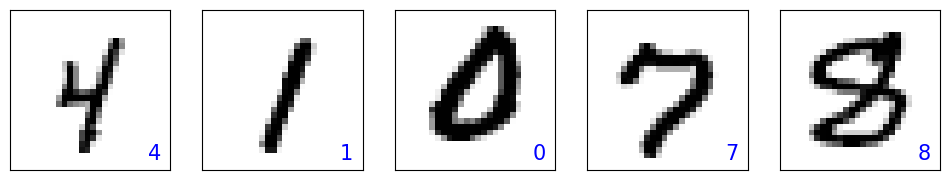

In [9]:
fig = plt.figure(figsize=[12, 4])
for i, img_label in enumerate(mnist_train.take(5)):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.set_xticks([]);
    ax.set_yticks([])
    img = img_label[0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(img_label[1]),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


In [10]:
tf.random.set_seed(42)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### Implementing a CNN using the TensorFlow Keras API

For implementing a CNN in TensorFlow, we use the Keras ```Sequential``` class to
stack different layers, such as convolution, pooling, and dropout, as well as the fully connected (_dense_) layers. The Keras layers API provides classes for each one: ```tf.keras.layers.Conv2D``` for a two-dimensional convolution layer; ```tf.keras.layers.MaxPool2D``` and ```tf.keras.layers.AvgPool2D``` for subsampling (maxpooling and average-pooling); and ```tf.keras.layers.Dropout``` for regularization using dropout. We will go over each of these classes in more detail.

#### Configuring CNN layers in Keras

Constructing a layer with the Conv2D class requires us to specify the number of output filters (which is equivalent to the number of output feature maps) and kernel sizes. In addition, there are optional parameters that we can use to configure a convolutional layer. The most commonly used ones are the strides (with a default value of 1 in both $x$, $y$ dimensions) and padding, which could be same or valid.

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

   Additional configuration parameters are listed in the [official documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D).

### Constructing a CNN in Keras

Now we can construct the CNN model that was shown in the previous figure. In the following code, we will use the `Sequential` class and add the convolution and pooling layers:

In [11]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))


So far, we have added two convolution layers to the model. For each convolutional layer, we used a kernel of size $5 × 5$ and 'same' padding. As discussed earlier, using `padding='same'` preserves the spatial dimensions (vertical and horizontal dimensions) of the feature maps such that the inputs and outputs have the same height and width (and the number of channels may only differ in terms of the number of filters used). The max-pooling layers with pooling size $2 × 2$ and strides of 2 will reduce the spatial dimensions by half. (Note that if the strides parameter is not specified in `MaxPool2D`, by default, it is set equal to the pooling size.)
While we can calculate the size of the feature maps at this stage manually, the Keras API provides a convenient method to compute this for us:

In [12]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 7, 7, 64)

By providing the input shape as a tuple specified in this example, the method
`compute_output_shape` calculated the output to have a shape `(16, 7, 7, 64)`,
indicating feature maps with 64 channels and a spatial size of $7 × 7$. The first dimension corresponds to the batch dimension, for which we used 16 arbitrarily. We could have used `None` instead, that is, `input_shape=(None, 28, 28, 1)`. The next layer that we want to add is a dense (or fully connected) layer for implementing a classifier on top of our convolutional and pooling layers. The input to this layer must have rank $2$, that is, shape $[𝑏atchsize × input\_units]$. Thus, we need to flatten the output of the previous layers to meet this requirement for the dense layer:

In [13]:
model.add(tf.keras.layers.Flatten())

model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 3136)

As the result of `compute_output_shape` indicates, the input dimensions for the
dense layer are correctly set up. Next, we will add two dense layers with a dropout layer in between:

In [14]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1',
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

The last fully connected layer, named `fc_2`, has 10 output units for the 10 class labels in the **MNIST** dataset. Also, we use the softmax activation to obtain the classmembership probabilities of each input example, assuming that the classes are mutually exclusive, so the probabilities for each example sum to 1. (This means that a training example can belong to only one class.) Based on what we discussed in the section Loss functions for classification, which loss should we use here? Remember that for a multiclass classification with integer (sparse) labels (as opposed to one-hot encoded labels), we use `SparseCategoricalCrossentropy`. The following code will call the `build()` method for late variable creation and compile the model:

In [15]:
tf.random.set_seed(42)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 10)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,274,634 (12.49 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

As you already know, we can train the model by calling the `fit()` method. Note
that using the designated methods for training and evaluation (like `evaluate()`
and `predict()`) will automatically set the mode for the dropout layer and rescale the hidden units appropriately so that we do not have to worry about that at all. Next, we will train this CNN model and use the validation dataset that we created for monitoring the learning progress:

In [19]:
import os
import pandas as pd
from tensorflow import keras

# As model training takes more than 30 minutes, we can re-use previously saved model
if os.path.exists('models'):
    model = keras.models.load_model('models/mnist-cnn.keras')
    history = pd.read_json('models/history.json')
else:
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`
    training = model.fit(mnist_train, epochs=NUM_EPOCHS,
                        validation_data=mnist_valid,
                        shuffle=True)
    history = training.history

Once the 20 epochs of training are finished, we can visualize the learning curves:

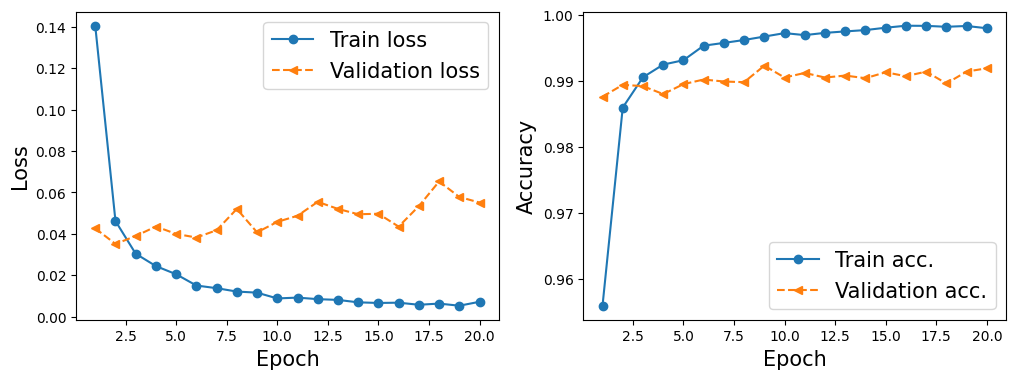

In [20]:
x_arr = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history['loss'], '-o', label='Train loss')
ax.plot(x_arr, history['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, history['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

As you already know, evaluating the trained model on the test dataset can be done by calling the `.evaluate()` method:

In [21]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9927 - loss: 0.0300

Test Acc. 99.17%


The CNN model achieves an accuracy near 99%. Finally, we can get the prediction results in the form of class-membership probabilities and convert them to predicted labels by using the `tf.argmax` function to find the element with the maximum probability. We will do this for a batch of 12 examples and visualize the input and predicted labels:

TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


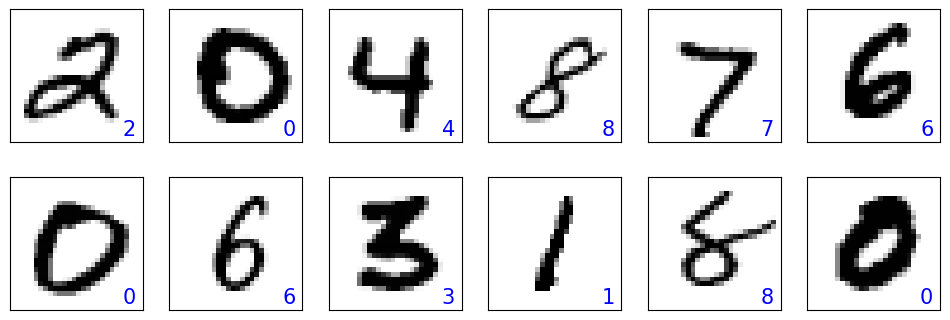

In [22]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()

In this set of plotted examples, all the predicted labels are correct.

In [ ]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

if not os.path.exists('models/mnist-cnn.keras'):
    model.save('models/mnist-cnn.keras')

if not os.path.exists('models/history.json'):
    pd.DataFrame(history).to_json('models/history.json')